# Summary of ImageNet/ResNet50 Training using Multiple Node

In [1]:
%matplotlib inline
import glob
import json
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('display.max_columns', 30)


project_dir = os.getcwd()
dir_anode_multi = f'{project_dir}/anode_multi'
dir_vnode_multi = f'{project_dir}/vnode_multi'

In [2]:
# function definitions

def read_data_from_files(dirpath, name, index_gpus=False):
    nnodes = [1, 2, 4, 8, 16, 32]
    index = []
    data = []
    for nnode in nnodes:
        file_pattern = f'{dirpath}/job{nnode:02d}.sh.o*'
        files = glob.glob(file_pattern)
        if not files:
            continue
        index.append(nnode)
        with open(files[0]) as inf:
            lines = inf.readlines()
            last_line = lines[-1].strip()
            record_str = last_line.split(' ')[-1]
            data.append(float(record_str))
    if index_gpus:
        if name == 'anode':
            ngpus = 8
        elif name == 'vnode':
            ngpus = 4
        index = [n * ngpus for n in index]
    return pd.Series(data=data, index=index, name=name)

def load_data(index_gpus=False):
    node_types = {
        'anode': dir_anode_multi,
        'vnode': dir_vnode_multi
    }

    series = []
    for node, dirpath in node_types.items():
        column_key = node
        data = read_data_from_files(dirpath, column_key, index_gpus)
        series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, title, legend_fontsize=None, xaxis_gpus=False):
    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    if xaxis_gpus:
        ax.set_xlabel('# of GPUs')
    else:
        ax.set_xlabel('# of Nodes')
    ax.set_ylabel('Time (seconds)')

    data0.dropna(how='all').plot.bar(ax=ax, rot=0)
    ax.legend(fontsize=legend_fontsize)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
print('Performance by changing number of nodes')
data

Performance by changing number of nodes


,anode,vnode
1,21247.42,87196.40
2,11441.05,44594.35
4,6223.11,22889.24
8,3432.30,12224.99
16,2019.90,6242.00
32,NaN,3321.17


In [4]:
data_gpus = load_data(index_gpus=True)
print('Performance by changing number of GPUs')
data_gpus

Performance by changing number of GPUs


,anode,vnode
4,NaN,87196.40
8,21247.42,44594.35
16,11441.05,22889.24
32,6223.11,12224.99
64,3432.30,6242.00
128,2019.90,3321.17


## Performance Ratio

In [5]:
# Do after results of single node are gotten.


# data_ratio = {
#     'fp32:a100_over_v100': data['anode:fp32'] / data['vnode:fp32'],
#     'amp:a100_over_v100': data['anode:amp'] / data['vnode:amp'],
#     'a100:amp_over_tf32': data['anode:amp'] / data['anode:fp32'],
#     'v100:amp_over_fp32': data['vnode:amp'] / data['vnode:fp32'],
# }
# pd.DataFrame(data=data_ratio)

## ComputeNode(A) vs. ComputeNode(V)

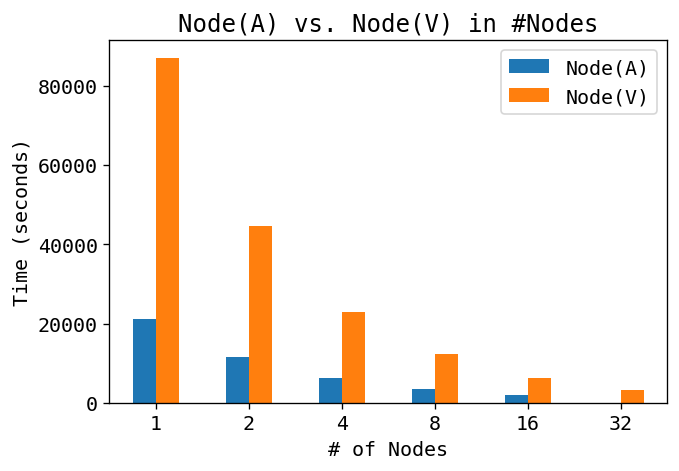

In [6]:
title = 'Node(A) vs. Node(V) in #Nodes'
column_labels = {
    'anode': 'Node(A)',
    'vnode': 'Node(V)',
}
plot(data, column_labels, title)

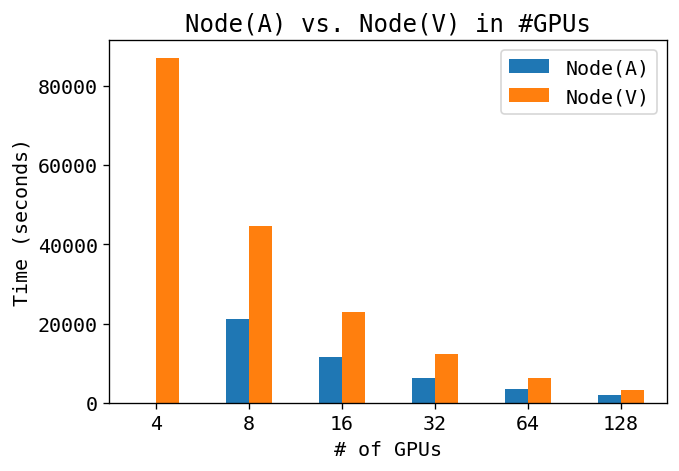

In [7]:
title = 'Node(A) vs. Node(V) in #GPUs'
column_labels = {
    'anode': 'Node(A)',
    'vnode': 'Node(V)',
}
plot(data_gpus, column_labels, title, xaxis_gpus=True)